In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import os
from sklearn.metrics import silhouette_score

import umap
from matplotlib.colors import ListedColormap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_fourier_z = pd.read_csv(os.path.join(folder_path, "features_fourier_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_fourier_mm = pd.read_csv(os.path.join(folder_path, "features_fourier_all_minmax.csv"))


In [3]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_z_cl= df_fourier_z.drop(columns=['filename', 'label'])

In [4]:
def _get_init_centers(n_clusters, n_samples):
    '''Return random unique indices as initial medoid centers'''
    return np.random.choice(n_samples, size=n_clusters, replace=False).tolist()

def _get_distance(data1, data2):
    '''Euclidean distance function'''
    return np.sqrt(np.sum((data1 - data2) ** 2))

def _get_cost(X, centers_id, dist_func):
    '''Return members, per-cluster costs, total cost, and distance matrix'''
    dist_mat = np.zeros((len(X), len(centers_id)))
    for j, center_id in enumerate(centers_id):
        center = X[center_id, :]
        for i in range(len(X)):
            if i == center_id:
                dist_mat[i, j] = 0.
            else:
                dist_mat[i, j] = dist_func(X[i, :], center)

    mask = np.argmin(dist_mat, axis=1)
    members = mask.copy()
    costs = np.array([np.sum(dist_mat[mask == i, i]) for i in range(len(centers_id))])
    return members, costs, np.sum(costs), dist_mat

def _kmedoids_run(X, n_clusters, dist_func, max_iter=1000, tol=0.001, verbose=True):
    n_samples = X.shape[0]
    centers = _get_init_centers(n_clusters, n_samples)
    if verbose:
        print("Initial centers are", centers)

    members, costs, tot_cost, dist_mat = _get_cost(X, centers, dist_func)
    cc, swapped = 0, True

    while swapped and cc < max_iter:
        swapped = False
        for i in range(n_samples):
            if i not in centers:
                for j in range(len(centers)):
                    new_centers = deepcopy(centers)
                    new_centers[j] = i
                    members_, costs_, tot_cost_, dist_mat_ = _get_cost(X, new_centers, dist_func)
                    if tot_cost - tot_cost_ > tol:
                        members, costs, tot_cost, dist_mat = members_, costs_, tot_cost_, dist_mat_
                        centers = new_centers
                        swapped = True
                        if verbose:
                            print("Change centers to", centers)
        cc += 1

    if verbose:
        if not swapped:
            print("End Searching by no swaps")
        else:
            print("End Searching by reaching maximum iteration", max_iter)

    return centers, members, costs, tot_cost, dist_mat, cc

class KMedoids:
    '''
    K-Medoids Clustering (PAM) Algorithm

    Parameters
    ----------
    n_clusters : int
        Number of clusters
    dist_func : callable
        Distance function (default: Euclidean)
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance to stop swapping
    '''
    def __init__(self, n_clusters, dist_func=_get_distance, max_iter=1000, tol=0.001):
        self.n_clusters = n_clusters
        self.dist_func = dist_func
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, plotit=True, verbose=True):
        self.X_train = X
        result = _kmedoids_run(
            X, self.n_clusters, self.dist_func, self.max_iter, self.tol, verbose
        )
        self.centers_, self.labels_, self.costs_, self.total_cost_, self.dist_mat_, self.n_iter_ = result

        if plotit and X.shape[1] == 2:
            self._plot_clusters(X)
        elif plotit:
            print("Plotting only supported for 2D data.")

    def predict(self, X):
        if not hasattr(self, "centers_"):
            raise RuntimeError("Model has not been fitted.")
        labels = np.zeros(len(X), dtype=int)
        for i, x in enumerate(X):
            dists = [self.dist_func(x, self.X_train[c]) for c in self.centers_]
            labels[i] = np.argmin(dists)
        return labels

    def _plot_clusters(self, X):
        plt.figure(figsize=(8, 6))
        cmap = plt.get_cmap('tab10')
        for i in range(self.n_clusters):
            cluster_points = X[self.labels_ == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        color=cmap(i), alpha=0.5, label=f'Cluster {i}')
            plt.scatter(X[self.centers_[i], 0], X[self.centers_[i], 1],
                        color=cmap(i), marker='*', s=300, edgecolor='k')
        plt.title("K-Medoids Clustering")
        plt.legend()
        plt.grid(True)
        plt.show()

Initial centers are [227, 29]
Change centers to [1, 29]
Change centers to [1, 2]
Change centers to [1, 5]
Change centers to [1, 16]
Change centers to [25, 16]
Change centers to [68, 16]
Change centers to [83, 16]
Change centers to [83, 92]
Change centers to [93, 92]
Change centers to [93, 123]
Change centers to [93, 151]
Change centers to [93, 243]
Change centers to [268, 243]
Change centers to [481, 243]
End Searching by no swaps
Etiquetas únicas: [0 1]


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


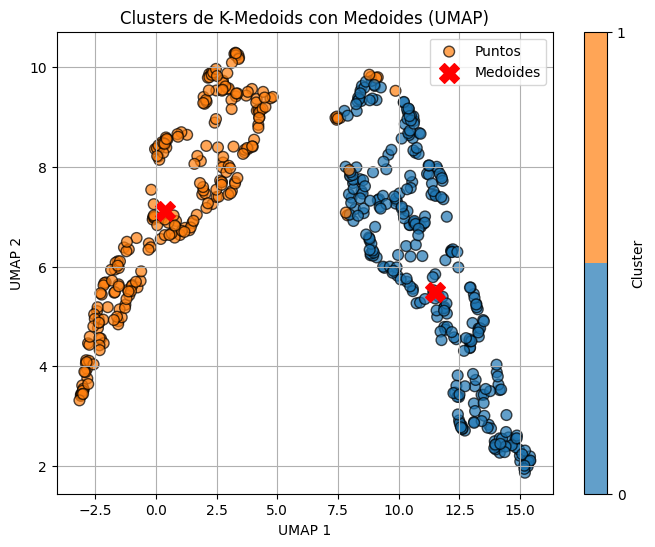

In [5]:
X = df_fourier_z_cl.to_numpy()

# Crear modelo K-Medoids con 2 clusters
model = KMedoids(n_clusters=2)
model.fit(X, plotit=False)

# Verifica que solo haya 2 etiquetas
print("Etiquetas únicas:", np.unique(model.labels_))

# Reducir dimensionalidad a 2D con UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2D = umap_model.fit_transform(X)

# Transformar coordenadas de los medoides al espacio 2D
medoids_2D = umap_model.transform(X[model.centers_])

# Definir colores fijos para 2 clusters
colors = ListedColormap(['#1f77b4', '#ff7f0e'])  # azul y naranja

# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2D[:, 0], X_2D[:, 1],
    c=model.labels_,
    cmap=colors,
    s=60,
    edgecolor='k',
    alpha=0.7,
    label="Puntos"
)

# Graficar medoides
plt.scatter(
    medoids_2D[:, 0], medoids_2D[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

# Detalles de la gráfica
plt.title("Clusters de K-Medoids con Medoides (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=[0, 1], label="Cluster")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
silhouette = silhouette_score(X, model.labels_)
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score: 0.527


In [7]:
# Asegúrate de tener las etiquetas reales
y_true = df_fourier_z['label']  # Ajusta si está en otra columna

# Etiquetas predichas por K-Medoids
y_pred = model.labels_

# Tabla de contingencia
contingency_table = pd.crosstab(y_true, y_pred, rownames=['Etiqueta Real'], colnames=['Cluster K-Medoids'])
print("Tabla de Contingencia:")
print(contingency_table)

Tabla de Contingencia:
Cluster K-Medoids    0    1
Etiqueta Real              
higher             235   33
smaller             55  214


In [8]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_fourier_mm_cl= df_fourier_mm.drop(columns=['filename', 'label'])

Initial centers are [401, 175]
Change centers to [401, 0]
Change centers to [401, 2]
Change centers to [401, 16]
Change centers to [401, 18]
Change centers to [401, 34]
Change centers to [401, 47]
Change centers to [401, 61]
Change centers to [83, 61]
Change centers to [93, 61]
Change centers to [93, 94]
Change centers to [109, 94]
Change centers to [109, 151]
Change centers to [109, 243]
Change centers to [268, 243]
Change centers to [481, 243]
End Searching by no swaps
Etiquetas únicas: [0 1]


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


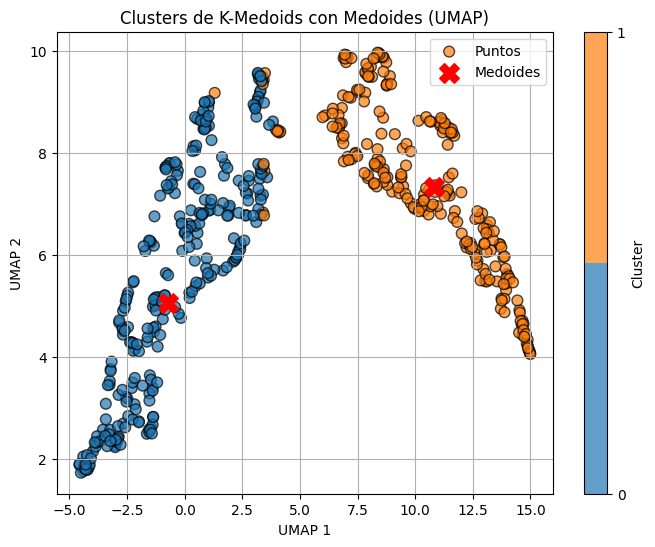

In [9]:
X_mm = df_fourier_mm_cl.to_numpy()

# Crear modelo K-Medoids con 2 clusters
model = KMedoids(n_clusters=2)
model.fit(X, plotit=False)

# Verifica que solo haya 2 etiquetas
print("Etiquetas únicas:", np.unique(model.labels_))

# Reducir dimensionalidad a 2D con UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2D = umap_model.fit_transform(X_mm)

# Transformar coordenadas de los medoides al espacio 2D
medoids_2D = umap_model.transform(X_mm[model.centers_])

# Definir colores fijos para 2 clusters
colors = ListedColormap(['#1f77b4', '#ff7f0e'])  # azul y naranja

# Graficar los clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2D[:, 0], X_2D[:, 1],
    c=model.labels_,
    cmap=colors,
    s=60,
    edgecolor='k',
    alpha=0.7,
    label="Puntos"
)

# Graficar medoides
plt.scatter(
    medoids_2D[:, 0], medoids_2D[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

# Detalles de la gráfica
plt.title("Clusters de K-Medoids con Medoides (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, ticks=[0, 1], label="Cluster")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
score = silhouette_score(X_mm, model.labels_)
print(f"Coeficiente de silueta: {score:.4f}")

Coeficiente de silueta: 0.5269


In [11]:
# Asegúrate de tener las etiquetas reales
y_true_mm = df_fourier_mm['label']  

# Etiquetas predichas por K-Medoids
y_pred_mm = model.labels_

# Tabla de contingencia
contingency_table_mm = pd.crosstab(y_true_mm, y_pred_mm, rownames=['Etiqueta Real'], colnames=['Cluster K-Medoids'])
print("Tabla de Contingencia:")
print(contingency_table_mm)

Tabla de Contingencia:
Cluster K-Medoids    0    1
Etiqueta Real              
higher             235   33
smaller             55  214
